<a href="https://colab.research.google.com/github/Yun-K/JokeServer/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Name: Yun Zhou
# ID:   300442776
#  # for using the vs code on colab
#  !pip install colabcode
# from colabcode import ColabCode
# ColabCode(port=10000,password="12345")

In [2]:
!pip install torchmetrics

     |████████████████████████████████| 282 kB 7.3 MB/s 


import libraries

In [3]:

import os
import time

import cv2
# import helper
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch  # PyTorch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics  # metrics like accuracy, recall, etc
import torchvision
import torchvision.transforms as transforms  # for image Transformation
import tqdm
from PIL import Image
from sklearn.datasets import load_digits
from sklearn.metrics import (accuracy_score, confusion_matrix, make_scorer,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_fscore_support, recall_score,
                             roc_auc_score)
from sklearn.model_selection import (KFold, LeaveOneOut, ShuffleSplit,
                                     cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.neural_network import MLPClassifier, MLPRegressor
from torch import nn
from torch.autograd import Variable
from torch.nn.modules.container import Sequential
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import (CosineAnnealingLR, ReduceLROnPlateau,
                                      StepLR)
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torch.utils.data.sampler import SubsetRandomSampler  # Sampler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

# import myutil


initialize some necessary global variable
And set up google colab path 
> https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

In [4]:
# for using CPU or GPU
# import torch 
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print("we can use:", DEVICE, "to run the Model ")

isColab = True  if torch.cuda.is_available() else False
isColab = !isColab #for CPU on colab

if isColab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  print("Use google drive")
  # !cd /content/gdrive/MyDrive/ && ls

# PREFIX_PATH = "/content/gdrive/MyDrive/"
DATA_PATH = "/content/gdrive/MyDrive/traindata" if isColab else "../traindata"

we can use: cpu to run the Model 
Mounted at /content/gdrive
Use google drive


load, preprocess and construct the dataset 

In [5]:
BATCH_SIZE = 64
train_size_coef = 0.8
RANDOM_SEED = 309

def load_preprocess_construct_data(path=DATA_PATH,BATCH_SIZE = BATCH_SIZE):
    dataset_whole = ImageFolder(path, transform=transforms.Compose(
        [
            # scale each images into the same size
            transforms.Resize((300, 300)),
            transforms.ToTensor(),  # transform them into tensor

            # normalize tensor images with mean and std
            # which means all channel of the input tensor images will be normalized
            transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                 std=(0.5, 0.5, 0.5), inplace=False),
            transforms.RandomRotation(degrees=(0, 180))
        ])
    )
    # split the data into train/valid set
    train_set, valid_set = train_test_split(dataset_whole, train_size=train_size_coef,
                                            random_state=RANDOM_SEED)
    # valid_set.
    # shuffle:TRUE means random sample
    # drop_last:False will make sure that no images will be droped even there are no enough BATCH_SIZE(e.g. 64) images at the last round
    train_loader = DataLoader(
        train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)
    valid_loader = DataLoader(
        valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=False)

    print(dataset_whole.classes)

    print("whole set len:", len(dataset_whole))
    print("train set len:", len(train_set))
    print("valid set len:", len(valid_set))
    print("train+valid set len:", len(train_set)+len(valid_set))

    return dataset_whole, train_set, valid_set, train_loader, valid_loader


dataset_whole, train_set, valid_set, train_loader, valid_loader = load_preprocess_construct_data()


['cherry', 'strawberry', 'tomato']
whole set len: 4457
train set len: 3565
valid set len: 892
train+valid set len: 4457


 use the tensorboard for visualize the data more convenient
 
 ``` 
tensorboard --logdir=preprocess
 ```

In [6]:
# preprocess_path  = "/content/gdrive/MyDrive/Colab_Notebooks/preprocess" if isColab else "preprocess"
# writer = SummaryWriter(preprocess_path)
# preprocess_step = 0
# for (image_X,target_Y) in train_loader:
#     # imgtensor=y-axis, global step = x axis
#     writer.add_images(tag="data", img_tensor=image_X, global_step=preprocess_step)
#     preprocess_step = preprocess_step + 1
# writer.close()

get the model 

In [7]:

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = Sequential(
            # nn.Conv2d(32, (3, 3), input_shape=(300, 300, 3),
            #           activation='sigmoid', padding='same'),
            nn.Flatten(),
            nn.Linear(270000, 64),
            # https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
            # nn.MaxPool2d(),
            # nn.Softshrink(),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),

            # 3 classes, so final out_chanel : 3
            nn.Linear(32, 3),
            nn.Dropout(0.3)    


        )

    def forward(self, X):
        """Do the forward pass on MLP

        Args:
            X ([type]): [description]

        """
        return self.layers(X)

    def to_model_string(self):
        return 'MLP'
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
print("we can use:", DEVICE, "to run the Model ")
model = MLP().to(DEVICE) #enable the GPU trian if we can 
print("Our model: ")
print(model)

we can use: cpu to run the Model 
Our model: 
MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=270000, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=3, bias=True)
    (6): Dropout(p=0.3, inplace=False)
  )
)


performance metric

In [8]:
def get_accuracy(net, testloader):
    """
    NOT USED in my CODE
    this code snipest is from:
    https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    """
    correct, total = 0, 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # print('Accuracy of the network on the 10000 test images: %d %%' % (
    # 100 * correct / total))
    return correct / total  # * 100

In [9]:

# initialize the torch metric  of accuracy
train_accuracy = torchmetrics.Accuracy().to(DEVICE)
valid_accuracy = torchmetrics.Accuracy().to(DEVICE)
# torchmetrics.Precision().to(DEVICE) #dont count other metrics since it is time consuming 

loss_function = nn.CrossEntropyLoss().to(DEVICE)

LEARNING_RATE, MOMENTUM = 0.0012, 0.9
# A Method for Stochastic Optimization_. The implementation of the L2 penalty follows changes proposed in Decoupled Weight Decay Regularization_.
optimizer = optim.Adam(model.parameters() ,lr=LEARNING_RATE) # lr=0.001 is default lr for Adam, set to higher since we use scheduler

# 
# optimizer = optim.RMSprop(model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)

# optimizer = optim.SGD(model.parameters(),lr=LEARNING_RATE, momentum=MOMENTUM)
# optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.99)

# scheduler = CyclicLR(optimizer, base_lr=lr, max_lr=0.01, step_size=5, mode='triangular2')
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# scheduler = lr_scheduler.CosineAnnealingLR(optimizer)

scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=3,T_mult=2)



train the model several epoches

In [10]:
# assert False
model = model.train()
total_step, valid_loss_min, valid_acc_min = 0, np.Inf, np.Inf
loss_train_list, loss_val_list, acc_train_list, acc_valid_list, cur_lr_list = [], [], [], [], []

best_model = None # for storing the best mode based on the lowest loss 
p = 0  # epoch numers of the validation set loss didn't decrease
stop = False  # whether stop the training process

iters = len(train_loader)
epoch_num = 35 if model.to_model_string()=='CNN' else 35
print('total epoch num',epoch_num)
for epoch in range(0, epoch_num):
    if stop:
        break
        
    # reset for current epoch
    train_accuracy.reset()
    valid_accuracy.reset()

    train_loss = []

    for batch_index, (image_X, target_Y) in enumerate(train_loader):
        total_step = total_step+1
        # enable the GPU train if we can
        image_X, target_Y = image_X.to(DEVICE), target_Y.to(DEVICE)

        # Sets the gradients of all optimized torch.Tensor s to zero.
        optimizer.zero_grad()

        # do the forward , back-propagation, and optimize
        outputs = model(image_X)
        loss = loss_function(outputs, target_Y)
        train_loss.append(loss.item())

        # store the accuracy
        preds = torch.max(outputs, 1)[1]
        train_accuracy(preds, target_Y)  # TODO:

        # BACKWARD and optimize
        loss.backward()
        optimizer.step()
        # #If call scheduler.step() after the end of an epoch,(i.e.outside this for loop)
        # #Then all batches in an epoch use the same learning rate,
        # #in order to make different batches use different learning rates
        # #we call it in there
        # scheduler.step(epoch + batch_index / iters)
        # cur_lr=optimizer.param_groups[-1]['lr']
        # cur_lr_list.append(cur_lr)
        # print('cur_lr:',cur_lr)
    # print('epoch_{}_end'.format(epoch))

    scheduler.step(epoch) 
    cur_lr=optimizer.param_groups[-1]['lr']
    cur_lr_list.append(cur_lr)

    final_train_acc = train_accuracy.compute().item()  # * 100
    acc_train_list.append(final_train_acc)
    # FIXME: DIFF ???  use np.mean() or need to divide by len(trainset)
    final_train_loss_mean = np.sum(train_loss)/len(train_set)
    loss_train_list.append(final_train_loss_mean)

    # for validation set
    model.eval()
    val_loss = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for batch_index, (image_X, target_Y) in enumerate(valid_loader):
            # enable the GPU  if we can
            image_X, target_Y = image_X.to(DEVICE), target_Y.to(DEVICE)
            outputs = model(image_X)
            loss = loss_function(outputs, target_Y)
            val_loss.append(loss.item())

            # store the accuracy
            preds = torch.max(outputs, 1)[1]
            valid_accuracy(preds, target_Y)  # TODO:
    final_valid_acc = valid_accuracy.compute().item()  # * 100
    acc_valid_list.append(final_valid_acc)

    # FIXME: DIFF ???  use np.mean() or need to divide by len(trainset)
    final_valid_loss_mean = np.sum(val_loss)/len(valid_set)
    loss_val_list .append(final_valid_loss_mean)
    print('-'*70)
    print('-'*70)
    print(time.ctime())
    print(
        f'Epoch {epoch}:', '\n', f'training step:{total_step}, train loss: {final_train_loss_mean:.4f}, valid loss: { final_valid_loss_mean:.4f}', \
        '\n',f"Learning rate:{cur_lr}" )
    print(f"Train set accuracy: {final_train_acc:.4f}")
    print(f"Valid set accuracy: {final_valid_acc:.4f}")

    scheduler.step(final_valid_loss_mean)

    # check if the loss on valid set is improved or not
    if final_valid_loss_mean <= valid_loss_min: # and final_valid_acc <= valid_acc_min:
        print('-'*10)
        print('Validation loss decreased ({:.8f} --> {:.8f}).  Saving model ...'.format(
            valid_loss_min,
            final_valid_loss_mean))
        best_model = model.state_dict() # assign this model since it perform better 
        # torch.save(model.state_dict(), MODEL_SAVE_PATH)
        valid_loss_min = final_valid_loss_mean
        p = 0  # reset P
    # else:
    #     print('-'*15)
    #     p += 1
    #     print(f'{p} epochs of increasing validation loss')
    #     if p >= 16:
    #         print(f'Stopping training since no improvement on the validation loss over {p} epoches ')
    #         stop = True
    #         break



total epoch num 20
----------------------------------------------------------------------
----------------------------------------------------------------------
Thu Oct 21 05:08:35 2021
Epoch 0: 
 training step:56, train loss: 0.0570, valid loss: 0.0280 
 Learning rate:0.0012
Train set accuracy: 0.3759
Valid set accuracy: 0.4339
----------
Validation loss decreased (inf --> 0.02803546).  Saving model ...
----------------------------------------------------------------------
----------------------------------------------------------------------
Thu Oct 21 05:08:53 2021
Epoch 1: 
 training step:112, train loss: 0.0189, valid loss: 0.0192 
 Learning rate:0.0010854101966249685
Train set accuracy: 0.4928
Valid set accuracy: 0.4406
----------
Validation loss decreased (0.02803546 --> 0.01917627).  Saving model ...
----------------------------------------------------------------------
----------------------------------------------------------------------
Thu Oct 21 05:09:10 2021
Epoch 2: 
 tr

plot the graph 

Finished the training process and plot graphs
RED is for validation set, BLUE is for train set 


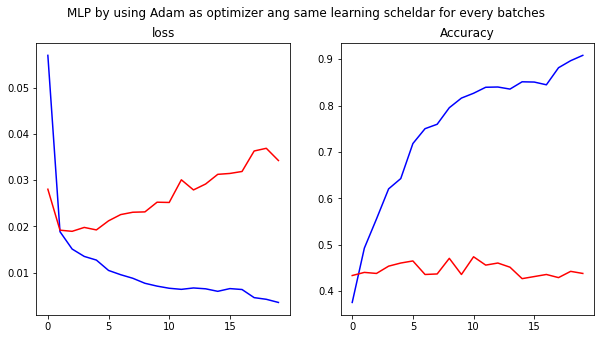

In [11]:
plt.figure(figsize=(10, 5))
plt.suptitle(model.to_model_string()+" by using Adam as optimizer ang same learning scheldar for every batches")

plt.subplot(1, 2, 1).set_title('loss')
plt.plot(loss_train_list, color='blue', label='train set')
plt.plot(loss_val_list, color='red', label='valid set')
plt.subplot(1, 2, 2).set_title('Accuracy')
plt.plot(acc_train_list, color='blue', label='train set')
plt.plot(acc_valid_list, color='red', label='valid set')
print('Finished the training process and plot graphs')
print("RED is for validation set, BLUE is for train set ")
plt.show()


plot graph for learning rate changes


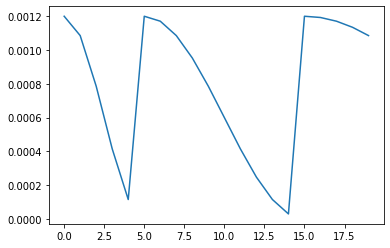

In [12]:
print('plot graph for learning rate changes')
x_list = list(range(len(cur_lr_list)))
plt.plot(x_list, cur_lr_list,label="learning rate plot")
plt.show()

In [13]:
# assert False
assert best_model is not None, "best model is not assigned correctly on above code"
SAVE_PATH = "/content/gdrive/MyDrive/Colab_Notebooks/model_Adam_MLP.pth"
torch.save(best_model, SAVE_PATH)